In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

# Import datasets

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),]
)

batch_size = 512

# data_path = '../../../../autoencoder/'
data_path = './'

trainset = torchvision.datasets.MNIST(root=data_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

testset = torchvision.datasets.MNIST(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [3]:
# Convert pytorch dataset to numpy array
def get_data(dataset):
    data = []
    train_labels = []
    for i, (inputs, labels) in enumerate(dataset):
        data.append(inputs)
        train_labels.append(labels)
    return torch.cat(data).numpy(), torch.cat(train_labels).numpy()

train_data, train_labels = get_data(trainloader)
test_data, test_labels = get_data(testloader)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(60000, 1, 28, 28) (60000,)
(10000, 1, 28, 28) (10000,)


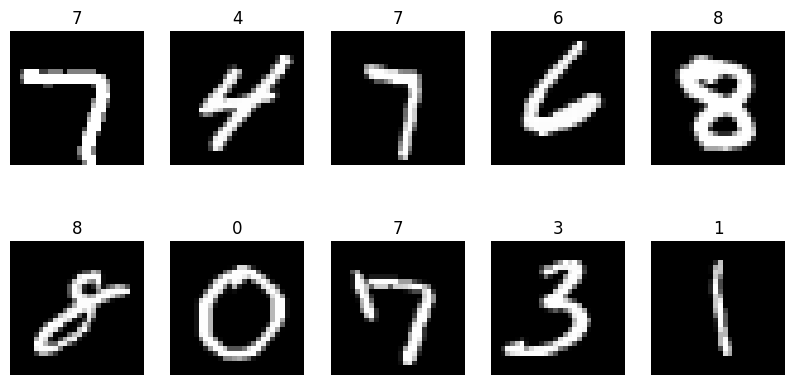

In [4]:
# Plot train_data sample
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i].reshape(28, 28), cmap='gray')
    plt.title(train_labels[i])
    plt.axis('off')
plt.show()

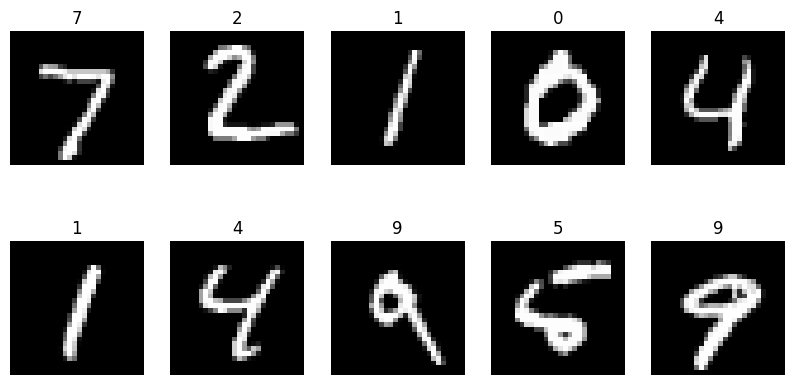

In [5]:
# Plot test_data sample
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_data[i].reshape(28, 28), cmap='gray')
    plt.title(test_labels[i])
    plt.axis('off')
plt.show()

# Create an autograd engine

In [6]:
class Tensor:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = np.zeros_like(data)
        self.grad2 = np.zeros_like(data)
        self._backward = lambda: None
        self._backward_second_order = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.requires_grad = True

    def shape(self):
        return self.data.shape

    def __repr__(self):
        return str(self.data)
    
    def __add__(self, other):
        if isinstance(other, Tensor):
            out = Tensor(self.data + other.data, (self, other), '+', label=f'{self.label}+{other.label}')
        else:
            out = Tensor(self.data + other, (self,), '+')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2 + self.grad2
                    if isinstance(other, Tensor) and other.requires_grad:
                         other.grad2 = out.grad2 + other.grad2
                else:
                    self.grad = out.grad + self.grad
                    if isinstance(other, Tensor) and other.requires_grad:
                        other.grad = out.grad + other.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def __sub__(self, other):
        if isinstance(other, Tensor):
            out = Tensor(self.data - other.data, (self, other), '-', label=f'{self.label}-{other.label}')
        else:
            out = Tensor(self.data - other, (self,), '-')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2 + self.grad2
                    if isinstance(other, Tensor) and other.requires_grad:
                         other.grad2 = -out.grad2 + other.grad2
                else:
                    self.grad = out.grad + self.grad
                    if isinstance(other, Tensor) and other.requires_grad:
                        other.grad = -out.grad + other.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def __mul__(self, other):
        if isinstance(other, Tensor):
            out = Tensor(self.data * other.data, (self, other), '*', label=f'{self.label}*{other.label}')
        else:
            out = Tensor(self.data * other, (self,), '*')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    if isinstance(other, Tensor):
                         self.grad2 = out.grad2 * other.data + self.grad2
                         if other.requires_grad:
                            other.grad2 = out.grad2 * self.data + other.grad2
                    else:
                         self.grad2 = out.grad2 * other + self.grad2
                else:    
                    if isinstance(other, Tensor):
                        self.grad = out.grad * other.data + self.grad
                        if other.requires_grad:
                            other.grad = out.grad * self.data + other.grad
                    else:
                        self.grad = out.grad * other + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def __getitem__(self, index):
        data = self.data[index]
        out = Tensor(data, (self,), 'getitem', label=f'{self.label}[{index}]')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                     self.grad2[index] = out.grad2 + self.grad2[index]
                else:
                    self.grad[index] = out.grad + self.grad[index]

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return Tensor(-self.data, (self,), 'neg', label=f'-{self.label}')
    
    def __rsub__(self, other):
        return -self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, exponent: float):
        data = self.data**exponent
        out = Tensor(data, (self,), f'**{exponent}', label=f'{self.label}**{exponent}')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2 * exponent * (exponent-1) * self.data ** (exponent - 2) + self.grad2
                else:
                    self.grad = out.grad * exponent * self.data ** (exponent - 1) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def dot(self, other):
        out_data = np.matmul(self.data, other.data)
        out = Tensor(out_data, (self, other), 'matmul', label=f'{self.label} matmul {other.label}')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    if isinstance(out.grad2, Tensor):
                        self.grad2 = out.grad2.dot(other.swapaxes(-1,-2)) + self.grad2
                        if other.requires_grad:
                            other.grad2 = self.swapaxes(-2,-1).dot(out.grad2) + other.grad2
                    else:
                        self.grad2 += np.matmul(out.grad2, other.data.swapaxes(-1, -2))
                        if other.requires_grad:
                            other.grad2 += np.matmul(self.data.swapaxes(-2, -1), out.grad2)
                else:
                    if isinstance(out.grad, Tensor):
                        self.grad = out.grad.dot(other.swapaxes(-1,-2)) + self.grad
                        if other.requires_grad:
                            other.grad = self.swapaxes(-2,-1).dot(out.grad) + other.grad
                    else:
                        self.grad += np.matmul(out.grad, other.data.swapaxes(-1, -2))
                        if other.requires_grad:
                            other.grad += np.matmul(self.data.swapaxes(-2, -1), out.grad)
                

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def T(self, axes=None):
        data = np.transpose(self.data, axes)
        out = Tensor(data, (self,), 'transpose', label=f'{self.label}.T')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if axes is None:
                    axes_inv = None
                else:
                    axes_inv = np.argsort(axes)
                
                if secondOrder:
                    if isinstance(out.grad2, Tensor):
                         self.grad2 = out.grad2.T(axes_inv) + self.grad2
                    else:
                         self.grad2 += np.transpose(out.grad2, axes_inv)
                else:
                    if isinstance(out.grad, Tensor):
                        self.grad = out.grad.T(axes_inv) + self.grad
                    else:
                        self.grad += np.transpose(out.grad, axes_inv)

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def swapaxes(self, axis1, axis2):
        data = np.swapaxes(self.data, axis1, axis2)
        out = Tensor(data, (self,), 'swapaxes', label=f'{self.label}.swapaxes({axis1}, {axis2})')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2.swapaxes(axis1, axis2) + self.grad2
                else:
                    self.grad = out.grad.swapaxes(axis1, axis2) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def sum(self, axis=None, keepdims=False):
        data = self.data.sum(axis=axis, keepdims=keepdims)
        out = Tensor(data, (self,), 'sum', label=f'{self.label} sum')

        def _backward(axis=axis, secondOrder=False):
            if self.requires_grad:
                grad_shape = np.ones_like(self.data.shape)
                if axis is not None:
                    if isinstance(axis, int):
                        axis = (axis,)
                    for ax in axis:
                        grad_shape[ax] = self.data.shape[ax]
                
                if secondOrder:
                    self.grad2 = out.grad2 * np.ones_like(self.data) + self.grad2
                else:
                    self.grad = out.grad * np.ones_like(self.data) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def flatten(self):
        data = self.data.flatten()
        out = Tensor(data, (self,), 'flatten', label=f'{self.label} flatten')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2.reshape(self.data.shape) + self.grad2
                else:
                    self.grad = out.grad.reshape(self.data.shape) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Tensor(data, (self,), 'relu', label=f'{self.label} relu')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = self.grad2
                else:
                    self.grad = out.grad * (self.data > 0) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def leaky_relu(self):
        data = np.maximum(0.01 * self.data, self.data)
        out = Tensor(data, (self,), 'leaky relu', label=f'{self.label} leaky relu')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = self.grad2
                else:
                    self.grad = out.grad * (self.data > 0) +  out.grad * (0.01 * (self.data < 0))

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Tensor(data, (self,), 'tanh', label=f'{self.label} tanh')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = -2 * out.grad2 * data * (1-data**2) + self.grad2
                else:
                    self.grad = out.grad * (1 - data**2) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def backward(self, secondOrder=False, hessian=False):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        if not hessian:
            self.grad = (1.0 * np.ones_like(self.data))
            if secondOrder:
                self.grad = Tensor(self.grad, label='grad')
                self.grad2 = 1.0 * np.ones_like(self.data)
                
            for node in reversed(topo):
                node._backward()

        else:
            self.grad2 = (1.0 * np.ones_like(self.data))
            for node in reversed(topo):
                node._backward_second_order()


    def get_hessian(self):
        """Get the Hessian of this tensor w.r.t. another tensor out."""
        
        n = self.data.shape[0]
        hessian = np.zeros((n, n))

        for i in range(n):
            # Do backward pass wrt i-th element of the gradient
            self.grad[i].backward(hessian=True)

            hessian[:,i] = self.grad2.squeeze()

            self.grad[i].zero_grad2()

        return hessian

    def zero_grad2(self):
        """Resets gradients of this tensor and all its descendants to zero."""
        self.grad2 = np.zeros_like(self.data)

        for child in self._prev:
            if isinstance(child, Tensor) and child.requires_grad:
                child.zero_grad2()

# Testing the autograd

In [7]:
# Check gradient and hessian of - xT P x + xT Q x
x = Tensor(np.random.randn(5, 1), label='x')
Q = Tensor(np.random.randn(5, 5), label='Q')
P = Tensor(np.random.randn(5, 5), label='P')
y = x.T().dot(Q).dot(x)
z = x.T().dot(P).dot(x)

y = y - z

y.backward(secondOrder=True)

print("Gradient")

print(x.grad)
print(Q.data @ x.data + Q.data.T @ x.data - (P.data @ x.data + P.data.T @ x.data))

print(f'{'-'*80}\n Hessian')

print(x.get_hessian())
print("Verification:\n", Q.data + Q.data.T - P.data - P.data.T)

Gradient
[[ 2.25260869]
 [-2.4673024 ]
 [-2.24779357]
 [ 0.56590759]
 [-8.06834315]]
[[ 2.25260869]
 [-2.4673024 ]
 [-2.24779357]
 [ 0.56590759]
 [-8.06834315]]
--------------------------------------------------------------------------------
 Hessian
[[-1.15108197 -0.17071919 -1.5586239   2.52772356  3.56683048]
 [-0.17071919 -0.34286909  2.46246702  1.24581071  0.32367437]
 [-1.5586239   2.46246702 -0.06583781 -3.07614388  1.86531067]
 [ 2.52772356  1.24581071 -3.07614388 -0.60374146 -0.70390081]
 [ 3.56683048  0.32367437  1.86531067 -0.70390081 -0.70211613]]
Verification:
 [[-1.15108197 -0.17071919 -1.5586239   2.52772356  3.56683048]
 [-0.17071919 -0.34286909  2.46246702  1.24581071  0.32367437]
 [-1.5586239   2.46246702 -0.06583781 -3.07614388  1.86531067]
 [ 2.52772356  1.24581071 -3.07614388 -0.60374146 -0.70390081]
 [ 3.56683048  0.32367437  1.86531067 -0.70390081 -0.70211613]]


In [8]:
# Checking shapes of dot products and gradients
a = Tensor(np.random.randn(3, 4, 5) * 1.0, label='a')
b = Tensor(np.random.randn(3, 5, 4) * 1.0, label='b')

c = a.dot(b)

# print(c.shape())
c.backward(secondOrder=True)

print(a.grad.data.dtype, b.grad.data.dtype)
print(a.grad.data.shape)
print(b.grad.shape())
print(isinstance(a.grad, np.ndarray), isinstance(b.grad, np.ndarray))
print(isinstance(a.grad, Tensor), isinstance(b.grad, Tensor))

float64 float64
(3, 4, 5)
(3, 5, 4)
False False
True True


# Define MLP

In [25]:
class SimpleMLP:
    def __init__(self, layer_sizes):
        # layer_sizes is a list of integers where each integer represents the number of neurons in that layer
        self.params = []
        self.layers = len(layer_sizes) - 1

        for i in range(self.layers):
            self.params.append(Tensor(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01))
            self.params.append(Tensor(np.zeros((1, layer_sizes[i+1]))))

    def forward(self, x):
        # Forward pass
        for i in range(self.layers):
            x = x.dot(self.params[2*i]) + self.params[2*i+1]
            if i < self.layers - 1:
                x = x.tanh()
        self.z = x
        return x

    def backward(self, y):
        # Backward pass with MSE loss
        loss = ((self.z - y) ** 2).sum() / y.data.shape[0]*1.0
        loss.backward()  # Use autograd to calculate gradients

        return loss

# Optimizers

In [150]:
class Adam:
    '''Adam optimizer'''
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(param.data) for param in model.params]
        self.v = [np.zeros_like(param.data) for param in model.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.model.params):
            if param.grad.shape != param.data.shape:
                param.grad = param.grad.sum(axis=0, keepdims=True)
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad**2
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            param.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        for param in self.model.params:
            param.grad *= 0

In [151]:
class Shampoo:
    def __init__(self, model, lr=1e-1, momentum=0, weight_decay=0, epsilon=1e-4, diag_cutoff=1e3, update_freq_sched=None, svd_rank=None, newton_num_iter=100, newton_num_iter_max_sv=50):
        self.model = model
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.epsilon = epsilon
        self.diag_cutoff = diag_cutoff
        self.update_freq_sched = update_freq_sched if update_freq_sched is not None else lambda x: 1
        self.svd_rank = svd_rank
        self.newton_num_iter = newton_num_iter
        self.newton_num_iter_max_sv = newton_num_iter_max_sv
        self.state = {}

        # Initialize preconditioners
        for p in model.params:
            self.state[p] = {}
            self.state[p]['step'] = 0
            if momentum > 0:
                self.state[p]['momentum_buffer'] = np.zeros_like(p.data)
            
            grad_size = p.data.shape
            for i, dim in enumerate(grad_size):
                if dim > diag_cutoff:
                    self.state[p][f'precond_{i}'] = epsilon * np.ones(dim)
                    self.state[p][f'inv_precond_{i}'] = np.zeros(dim)
                else:
                    self.state[p][f'precond_{i}'] = epsilon * np.eye(dim)
                    self.state[p][f'inv_precond_{i}'] = np.zeros((dim, dim))

    def matrix_pow_svd(self, matrix, power):
        """ Compute approximate power of a matrix using svd """
        u, s, v = np.linalg.svd(matrix)
        rank = self.svd_rank
        if rank is not None:
            rank = min(rank, min(matrix.shape))
            # Truncated SVD
            s = s[:rank]
            u = u[:, :rank]
            v = v[:rank, :]
        result = u @ np.diag(s**power) @ v
        return result

    def max_sv(self, G, error_tolerance=1e-6):
        """Computes the largest singular value of G using power iteration."""
        num_iters = self.newton_num_iter_max_sv
        n = G.shape[0]
        v = np.random.randn(n)
        sv = 0

        for _ in range(num_iters):
            v_hat = v / np.linalg.norm(v)
            v = G @ v_hat
            new_sv = v_hat @ v
            if abs(new_sv - sv) < error_tolerance:
                break
            sv = new_sv

        return sv

    def matrix_pow_newton(self, G, power, error_tolerance=1e-5, ridge_epsilon=1e-6):
        """Computes G^(-1/power) using Coupled Newton Iteration."""
        num_iters = self.newton_num_iter
        mat_size = G.shape[0]
        identity = np.eye(mat_size)
        max_eigenvalue = self.max_sv(G)
        ridge_epsilon = ridge_epsilon * max(max_eigenvalue, 1e-16)
        damped_mat_g = G + ridge_epsilon * identity

        alpha = -1.0 / power
        z = (1 + power) / (2 * np.linalg.norm(damped_mat_g))
        mat_m = damped_mat_g * z
        mat_h = identity * z**(1 / power)
        error = np.max(np.abs(mat_m - identity))

        for _ in range(num_iters):
            if error < error_tolerance:
                break

            mat_m_i = (1 - alpha) * identity + alpha * mat_m
            mat_h = mat_h @ mat_m_i
            mat_m = np.linalg.matrix_power(mat_m_i, power) @ mat_m
            error = np.max(np.abs(mat_m - identity))

        return mat_h

    def step(self):
        for p in self.model.params:
            # Skip parameters without gradients
            if p.grad is None:
                continue
            if p.grad.shape != p.data.shape:
                p.grad = p.grad.sum(axis=0, keepdims=True)

            # Get the gradient
            grad = p.grad if isinstance(p.grad, np.ndarray) else p.grad.data
            n_dim = len(grad.shape)
            grad_size = grad.shape
            momentum = self.momentum
            weight_decay = self.weight_decay
            state = self.state[p]
            
            # Update frequency of preconditioner
            update_freq = self.update_freq_sched(state['step'])

            # Apply momentum and weight decay
            if momentum > 0:
                grad = grad * (1 - momentum) + state['momentum_buffer'] * momentum
            if weight_decay > 0:
                grad = grad + p.data * weight_decay

            for i, dim in enumerate(grad_size):
                # Get the preconditioner
                precond = state[f'precond_{i}']
                inv_precond_pow = state[f'inv_precond_{i}']

                grad = np.transpose(grad, (i, *range(i), *range(i + 1, n_dim)))
                grad_size_t = grad.shape
                grad = grad.reshape(dim, -1)

                # Update the preconditioner
                if dim > self.diag_cutoff:
                    precond += np.diagonal(grad @ grad.T)
                    if state['step'] % update_freq == 0:
                        inv_precond_pow = np.power(precond, -1 / (2*n_dim))
                else:
                    precond += grad @ grad.T
                    if state['step'] % update_freq == 0:
                        # inv_precond_pow = self.matrix_pow_svd(precond, -1 / (2*n_dim))
                        inv_precond_pow = self.matrix_pow_newton(precond, 2*n_dim)

                # Apply preconditioning
                if i == n_dim - 1:
                    if dim > self.diag_cutoff:
                        grad = grad.T @ np.diag(inv_precond_pow)
                    else:
                        grad = grad.T @ inv_precond_pow
                    grad = grad.reshape(grad_size)

                else:
                    if dim > self.diag_cutoff:
                        grad = np.diag(inv_precond_pow) @ grad
                    else:
                        grad = inv_precond_pow @ grad
                    grad = grad.reshape(grad_size_t)
                
            # Update the parameters and state
            state['step'] += 1
            state['momentum_buffer'] = grad
            p.data = p.data - grad * self.lr

    def zero_grad(self):
        ''' Reset gradients after step '''
        for param in self.model.params:
            param.grad *= 0

In [152]:
class NaturalGradientDescent:
    def __init__(self, model, lr=1e-1, tol=1e-5, max_iter=1000):
        self.model = model
        self.lr = lr
        self.tol = tol
        self.max_iter = max_iter

    def compute_fisher_vector_product(self, grad):
        """Compute Fisher as a vector product"""
        original_shape = grad.shape
        # Flatten to 2D: (batch_size, -1)
        grad_flat = grad.reshape(original_shape[0], -1)
        # Compute Fisher matrix
        fisher_matrix = grad_flat @ grad_flat.T + 1e-5 * np.eye(grad_flat.shape[0])
        return fisher_matrix, original_shape
    
    def conjugate_gradient(self, fisher_matrix, grad, tol, max_iter):
        """Conjugate gradient method to solve for F^-1 @ grad"""
        original_shape = grad.shape
        grad_flat = grad.reshape(original_shape[0], -1)
        
        x = np.zeros_like(grad_flat)
        r = grad_flat.copy()
        p = r.copy()
        rs_old = np.sum(r * r)

        for _ in range(max_iter):
            Ap = fisher_matrix @ p
            alpha = rs_old / (np.sum(p * Ap) + 1e-8)
            x += alpha * p
            r -= alpha * Ap
            rs_new = np.sum(r * r)

            if np.sqrt(rs_new) < tol:
                break

            p = r + (rs_new / rs_old) * p
            rs_old = rs_new

        # Reshape solution back to original dimensions
        return x.reshape(original_shape)

    def step(self):
        for p in self.model.params:
            if p.grad is None:
                continue
            if p.grad.shape != p.data.shape:
                p.grad = p.grad.sum(axis=0, keepdims=True)
            grad = p.grad if isinstance(p.grad, np.ndarray) else p.grad.data

            fisher_matrix, original_shape = self.compute_fisher_vector_product(grad)
            natural_grad = self.conjugate_gradient(fisher_matrix, grad, self.tol, self.max_iter)
            p.data = p.data - natural_grad * self.lr

    def zero_grad(self):
        for param in self.model.params:
            param.grad *= 0

# Train MLP on MNIST dataset

In [192]:
# Create a neural network for mnist
np.random.seed(0)
mlp = SimpleMLP([784, 128, 10])

In [193]:
def update_freq_sched(step):
    return 1
optimizer = Shampoo(mlp,
    lr=1e-1,
    epsilon=1e-4,
    weight_decay=1e-4,
    diag_cutoff=1e1,
    update_freq_sched=update_freq_sched,
    svd_rank=None,
    newton_num_iter=10,
    newton_num_iter_max_sv=10
)
# optimizer = Adam(mlp, lr=1e-2)
optimizer = NaturalGradientDescent(mlp, lr=1.5e-2, tol=1e-5, max_iter=2)

In [194]:
# Batch gradient descent with train_data, train_labels
epochs = 1

for epoch in range(epochs):
    total_loss = 0
    batch_size = 512
    for i in range(0, len(train_data), batch_size):
        # Zero gradients
        optimizer.zero_grad()
        
        bt_shape = train_data[i:i+batch_size].shape
        x = Tensor(train_data[i:i+batch_size].reshape(bt_shape[0], -1))
        
        # Convert labels to one-hot encoding
        y_onehot = np.zeros((bt_shape[0], 10))
        y_onehot[np.arange(bt_shape[0]), train_labels[i:i+bt_shape[0]]] = 1
        y = Tensor(y_onehot)
        
        # Forward pass
        y_pred = mlp.forward(x)

        # Calculate loss
        loss = mlp.backward(y)
        total_loss += loss.data

        # Backward pass
        optimizer.step()
        
        if (i % 100 == 0):
            # Calculate accuracy
            y_pred_labels = np.argmax(y_pred.data, axis=1)
            accuracy = np.mean(y_pred_labels == train_labels[i:i+bt_shape[0]])
            print(f'Batch {i}/{len(train_data)}: Loss: {total_loss / (i+1)}, Accuracy: {accuracy*100}%')
    
    print(f'Epoch {epoch+1}/{epochs}: Loss: {total_loss / len(train_data)}')

Batch 0/60000: Loss: 1.0017088234225717, Accuracy: 5.6640625%
Batch 12800/60000: Loss: 0.0013755052859631182, Accuracy: 80.078125%
Batch 25600/60000: Loss: 0.0012188575437103299, Accuracy: 81.4453125%
Batch 38400/60000: Loss: 0.0011387113280659088, Accuracy: 79.6875%
Batch 51200/60000: Loss: 0.0010720790613857618, Accuracy: 82.421875%
Epoch 1/1: Loss: 0.0010393954815031475


In [195]:
# Calculate accuracy on test set
x = Tensor(test_data.reshape(len(test_data), -1))
y = Tensor(test_labels.reshape(len(test_labels), -1))
y_pred = mlp.forward(x)
y_pred = np.argmax(y_pred.data, axis=1)
accuracy = np.mean(y_pred == test_labels)
print(f'Accuracy: {accuracy*100}')

Accuracy: 89.37
